In [2]:
# 2019-11-14
# A. Pendleton
# Co-expression network plots

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob

#Plotting networks
import networkx as nx


In [4]:
# For interactivity
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) #Make it work in notebook mode
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


init_notebook_mode(connected=True)



# Goal of script:

Draw coexpression networks for modules that contain:
    - genes of interest (searched by name or function)
    - genes with desired expression patterns

Searching/filtration steps using the website's interface will yield a list/array of gene identifiers.

#### Practice gene list

For practice, this script will be fed a test geneList:

In [5]:
geneList = ['Sevir.5G058900', 'Sevir.5G254600', 'Sevir.2G052500']


_____

# User provided information

In [6]:
rootDir = '/depot/jwisecav/data/pendlea/coexpression_assessments/development/coexp_development/'

annotationFile = rootDir + 'Genes_annotations.txt'

_____

# Functional Annotations of Genes

In [18]:
annotationDict = {}

columnNames = []

lineCount = 0
for line in open(annotationFile, 'r'):
    line=line.rstrip().split('\t')
    
    lineCount += 1
    
    #Get content information from the column names in the header line
    if lineCount == 1:
        for c in range(0,len(line)):
            columnNames.append(line[c])
        continue
    
    #Find gene ID in column 1
    geneID = line[0]
    
    #If gene not in the dictionary... create entry
    if geneID not in annotationDict.keys():
        annotationDict[geneID] = {}
        for columnName in columnNames:
            annotationDict[geneID][columnName] = ''
    else: #skip if already in dictionary 
        continue

    #Now store all the relevant information in the line to this gene model
    for c in range(1, len(line)): #go through each column and store its data in the dictionary for this gene
        """print(c,line[c])
        sys.exit()
        #If there are commas in the name, then let's convert the string to a list to be stored
        if ',' in line[c] or ';' in line[c]:
            dataLine = str(line[c]).split(',').split(';')
        else:
            dataLine = line[c]"""
        dataLine = line[c]  
        #Store in relevant column name
        columnName = columnNames[c]
        annotationDict[geneID][columnName] = dataLine
    

print('%i genes in annotation dictionary' % len(annotationDict.keys()))


38334 genes in annotation dictionary


_____

# Network processing

### Get networks that user has provided information for

In [8]:
networks = []

#Get a list of the network directories the user has in their Networks path
for directory in glob.glob(rootDir + 'Networks/*/'):
    networkDecay = directory.rsplit('/',2)[1].split('_')[1]
    networks.append(networkDecay)


### Parse each summary file per network decay value
Store the module identifiers that have at least one of the genes in our geneList

In [9]:
networksToPlot = []

#Go through each decay value that the user has provided data for (Note. this can be just one decay value/level)
for networkDecay in networks:
    #Find the relevant summary file based on what the decay value is
    networkRootDir =  rootDir + 'Networks/' + 'Network_%s/' % networkDecay
    summaryFile = networkRootDir + 'Module_Summary.txt'
    
    #Parse each line of the summary file
    for line in open(summaryFile, 'r'):
        line=line.rstrip().split('\t') #Strip line and split by tab
        
        #skip headerline
        if '#' in line[0]:
            continue
    
        networkID = line[0] #The network id is column #1
        networkABCFile = networkRootDir + networkID + '.abc' #The edgeweight file is simply networkID.abc in the same directory
        genesInNetwork = line[3].split(' ') #Space-delimited list of genes in the network (so split by space to make a list)
        
        #Go through each gene and see if its in your gene list 
        for gene in genesInNetwork: 
            #If so, then add its relevant network ID to an array that stores the edgeweight files
            #.    for all networks to plot
            if gene in geneList and networkABCFile not in networksToPlot:
                networksToPlot.append(networkABCFile)
                
print('%i networks to plot' % len(networksToPlot))

10 networks to plot


# 3D Networks

In [33]:
def get_annotation_text(annotationDict, geneID):
    text = ''
    
    text += 'Gene ID: %s<br>' % geneID
    for c in annotationDict[geneID]:
        #Skip if there's no annotation information
        if annotationDict[geneID][c] == '':
            continue
        if '#Gene' in c:
            continue
        text += '%s: %s<br>' % (c, annotationDict[geneID][c])

    return text

In [63]:
network = networksToPlot[0]
moduleID = network.rsplit('/',1)[1].replace('.abc','') #extract module ID from the module file

#Define the edgeweight file
edgeWeightFile = network

#Matplotlib defined clearing and size determination of plot
"""fig = plt.figure(figsize=[20,20])
ax = plt.subplot(111)"""

#Create empty graph for networkX
G = nx.Graph()
G = nx.read_weighted_edgelist(edgeWeightFile)
pos=nx.spring_layout(G, dim=3) #This is a randomized layout of the network

labels = pos.keys()

#Edge traces
edge_trace = go.Scatter3d(
    x=[],
    y=[],
    z=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0, z0 = pos[edge[0]]#G.node[edge[0]]['pos']
    x1, y1, z1 = pos[edge[1]] #G.node[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
    edge_trace['z'] += tuple([z0, z1, None])

#NODE TRACES
node_trace = go.Scatter3d(
    x=[],
    y=[],
    z=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=[],
        size=22,
        ))

#ADD X,Y POSITIONS OF EACH NODE/GENE
for node in G.nodes():
    x, y, z = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['z'] += tuple([z])


#DEFINE COLORS OF NODES
colors = []

for node in G.nodes():
    geneID = node 
    #If gene is in candidate gene list -- then they're blue, else they're gray
    if geneID in geneList:
        colors.append('dodgerblue')
    else:
        colors.append('lightgray')
    #node_info = '# of connections: '+str(len(adjacencies[1]))
    text = get_annotation_text(annotationDict, geneID)
    
    node_trace['text'] +=tuple([text])
    
node_trace['marker']['color'] = colors

axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

#DRAW GRAPH
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network %s' % moduleID,
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                plot_bgcolor= 'rgba(0,0,0,0)',
                scene=dict(
                xaxis=dict(axis),
                yaxis=dict(axis),
                zaxis=dict(axis))))
iplot(fig, filename='networkx')



# TESTING!!!!

In [53]:
for edge in G.edges(): #Get x,y,z coordinates for each pair of genes in network
    x0, y0, z0 = pos[edge[0]] 
    x1, y1, z1 = pos[edge[1]] 
    print(x0, y0, z0)
    print(edge)
    break
for edge in G.edges(data=True):
    print(edge[2]['weight'])
    break

-0.021548334361049335 0.08693997952372538 0.5030945765381638
('Sevir.3G067800', 'Sevir.7G022600')
0.6390963841907118


In [ ]:
def make_edge(x, y, z, width):
    """
    Args:
        x: a tuple of the x from and to, in the form: tuple([x0, x1, None])
        y: a tuple of the y from and to, in the form: tuple([y0, y1, None])
        width: The width of the line

    Returns:
        a Scatter plot which represents a line between the two points given. 
    """
    return  go.Scatter3d(
                x=x,
                y=y,
                z=z,
                line=dict(width=width,color='#888'),
                hoverinfo='none',
                mode='lines')

In [60]:
network = networksToPlot[0]
moduleID = network.rsplit('/',1)[1].replace('.abc','') #extract module ID from the module file

#Define the edgeweight file
edgeWeightFile = network

#Create empty graph for networkX
G = nx.Graph()
G = nx.read_weighted_edgelist(edgeWeightFile)
pos=nx.spring_layout(G, dim=3) #This is a randomized layout of the network

labels = pos.keys()

#Edge traces
edge_trace = go.Scatter3d(
    x=[],
    y=[],
    z=[],
    line=Line(width=[],color='#888'),
    hoverinfo='none',
    mode='lines')


for edge in G.edges(): #Get x,y,z coordinates for each pair of genes in network
    x0, y0, z0 = pos[edge[0]] 
    x1, y1, z1 = pos[edge[1]] 
    edge_trace['x'] += tuple([x0, x1, None]) #append to the defined (x=[]) in above loop
    edge_trace['y'] += tuple([y0, y1, None]) #append to the defined (y=[]) in above loop
    edge_trace['z'] += tuple([z0, z1, None]) #append to the defined (z=[]) in above loop
    
#GET LINE WIDTHS
for edge in G.edges(data=True):
    edgeWeight = float(edge[2]['weight'])
    lineWidth = 2*edgeWeight
    print(edgeWeight,lineWidth)
    edge_trace['lines'] += tuple(lineWidth)

#NODE TRACES
node_trace = go.Scatter3d(
    x=[],
    y=[],
    z=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=[],
        size=20,
        ))

#ADD X,Y POSITIONS OF EACH NODE/GENE
for node in G.nodes():
    x, y, z = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['z'] += tuple([z])


#DEFINE COLORS OF NODES AND HOVER TEXT
colors = []

for node in G.nodes():
    geneID = node 
    #GET GENE COLOR
    #If gene is in candidate gene list -- then they're blue, else they're gray
    if geneID in geneList:
        colors.append('dodgerblue')
    else:
        colors.append('lightgray')
    #WHEN YOU HOVER - WHAT TEXT DO YOU WANT TO APPEAR?
    #node_info = '# of connections: '+str(len(adjacencies[1]))
    #This function (get_annotation_text)generates a string made of what's stored in the annotation 
    #      dictionary (provided by user gene_annotation.txt), if empty, all it'll say is the "geneID: X"
    text = get_annotation_text(annotationDict, geneID) 
    node_trace['text'] +=tuple([text])   #add the text as a tuple to store in the node trace
    
node_trace['marker']['color'] = colors

axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

#DRAW GRAPH
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network %s' % moduleID,
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                plot_bgcolor= 'rgba(0,0,0,0)',
                scene=dict(
                xaxis=dict(axis),
                yaxis=dict(axis),
                zaxis=dict(axis))))
iplot(fig, filename='networkx')


ValueError: Invalid property specified for object of type plotly.graph_objs.Scatter3d: 'lines'

    Valid properties:
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the provided data arrays are connected.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on plot.ly for  customdata .
        error_x
            plotly.graph_objects.scatter3d.ErrorX instance or dict
            with compatible properties
        error_y
            plotly.graph_objects.scatter3d.ErrorY instance or dict
            with compatible properties
        error_z
            plotly.graph_objects.scatter3d.ErrorZ instance or dict
            with compatible properties
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on plot.ly for  hoverinfo .
        hoverlabel
            plotly.graph_objects.scatter3d.Hoverlabel instance or
            dict with compatible properties
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}". https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format for
            details on the formatting syntax. Dates are formatted
            using d3-time-format's syntax %{variable|d3-time-
            format}, for example "Day: %{2019-01-01|%A}".
            https://github.com/d3/d3-3.x-api-
            reference/blob/master/Time-Formatting.md#format for
            details on the date formatting syntax. The variables
            available in `hovertemplate` are the ones emitted as
            event data described at this link
            https://plot.ly/javascript/plotlyjs-events/#event-data.
            Additionally, every attributes that can be specified
            per-point (the ones that are `arrayOk: true`) are
            available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on plot.ly for  hovertemplate
            .
        hovertext
            Sets text elements associated with each (x,y,z)
            triplet. If a single string, the same string appears
            over all the data points. If an array of string, the
            items are mapped in order to the this trace's (x,y,z)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on plot.ly for  hovertext .
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on plot.ly for  ids .
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        line
            plotly.graph_objects.scatter3d.Line instance or dict
            with compatible properties
        marker
            plotly.graph_objects.scatter3d.Marker instance or dict
            with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on plot.ly for  meta .
        mode
            Determines the drawing mode for this scatter trace. If
            the provided `mode` includes "text" then the `text`
            elements appear at the coordinates. Otherwise, the
            `text` elements appear on hover. If there are less than
            20 points and the trace is not stacked then the default
            is "lines+markers". Otherwise, "lines".
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        projection
            plotly.graph_objects.scatter3d.Projection instance or
            dict with compatible properties
        scene
            Sets a reference between this trace's 3D coordinate
            system and a 3D scene. If "scene" (the default value),
            the (x,y,z) coordinates refer to `layout.scene`. If
            "scene2", the (x,y,z) coordinates refer to
            `layout.scene2`, and so on.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stream
            plotly.graph_objects.scatter3d.Stream instance or dict
            with compatible properties
        surfaceaxis
            If "-1", the scatter points are not fill with a surface
            If 0, 1, 2, the scatter points are filled with a
            Delaunay surface about the x, y, z respectively.
        surfacecolor
            Sets the surface fill color.
        text
            Sets text elements associated with each (x,y,z)
            triplet. If a single string, the same string appears
            over all the data points. If an array of string, the
            items are mapped in order to the this trace's (x,y,z)
            coordinates. If trace `hoverinfo` contains a "text"
            flag and "hovertext" is not set, these elements will be
            seen in the hover labels.
        textfont
            plotly.graph_objects.scatter3d.Textfont instance or
            dict with compatible properties
        textposition
            Sets the positions of the `text` elements with respects
            to the (x,y) coordinates.
        textpositionsrc
            Sets the source reference on plot.ly for  textposition
            .
        textsrc
            Sets the source reference on plot.ly for  text .
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}". https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format for
            details on the formatting syntax. Dates are formatted
            using d3-time-format's syntax %{variable|d3-time-
            format}, for example "Day: %{2019-01-01|%A}".
            https://github.com/d3/d3-3.x-api-
            reference/blob/master/Time-Formatting.md#format for
            details on the date formatting syntax. Every attributes
            that can be specified per-point (the ones that are
            `arrayOk: true`) are available.
        texttemplatesrc
            Sets the source reference on plot.ly for  texttemplate
            .
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xsrc
            Sets the source reference on plot.ly for  x .
        y
            Sets the y coordinates.
        ycalendar
            Sets the calendar system to use with `y` date data.
        ysrc
            Sets the source reference on plot.ly for  y .
        z
            Sets the z coordinates.
        zcalendar
            Sets the calendar system to use with `z` date data.
        zsrc
            Sets the source reference on plot.ly for  z .
        

# Draw networks

N010M00022


/depot/jwisecav/apps/Anaconda/envs/env.genomics/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



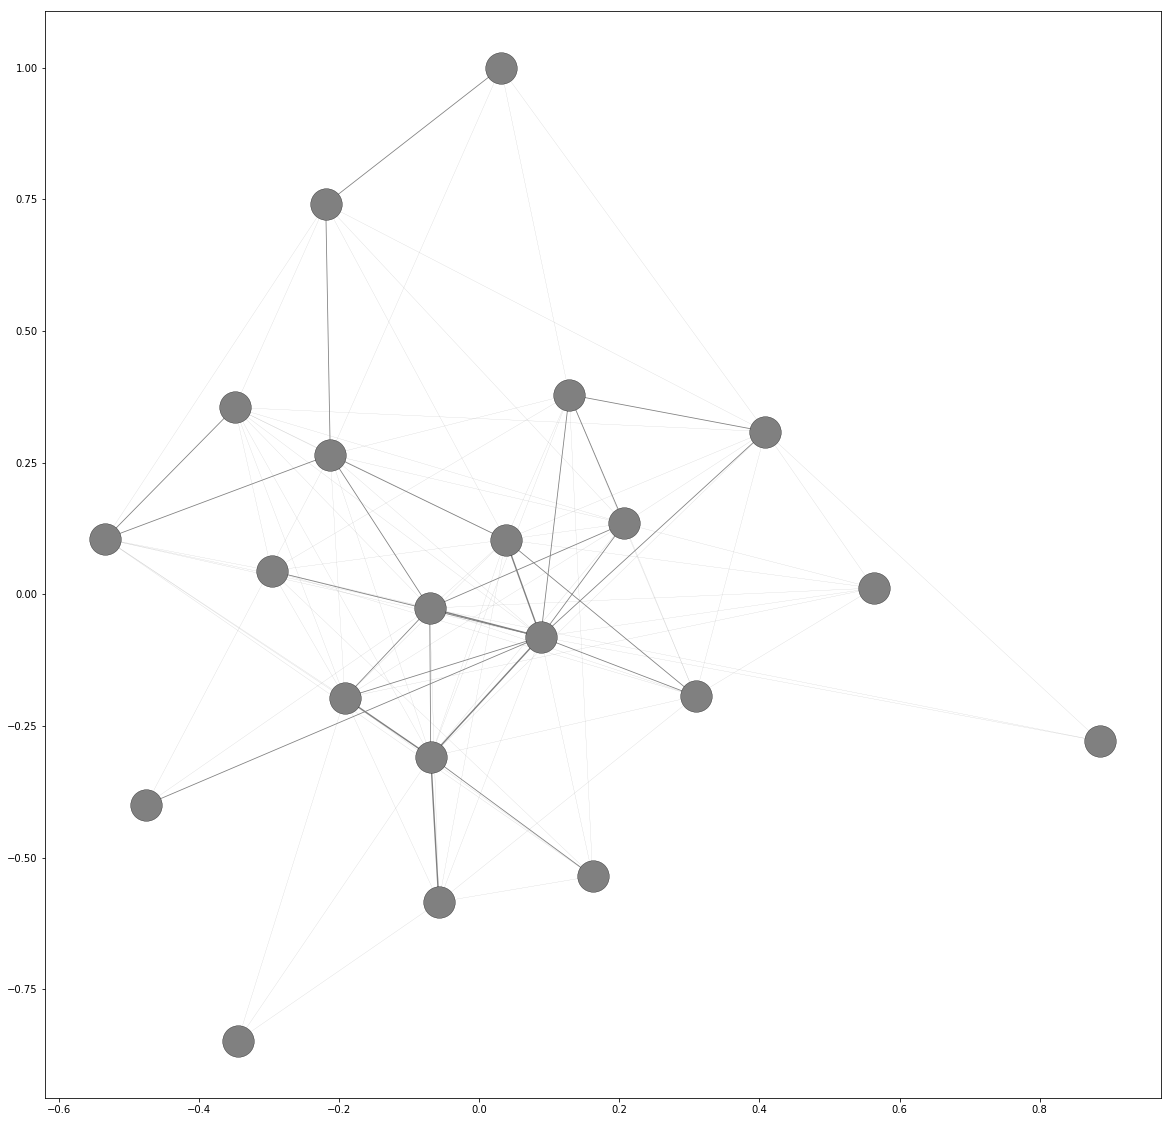

In [10]:
defaultNodeColor = 'gray'
defaultNodeOutlineColor = 'black'
nodeSize = 1000

for network in networksToPlot:
    moduleID = network.rsplit('/',1)[1].replace('.abc','') #extract module ID from the module file
    print(moduleID)
    
    #Define the edgeweight file
    edgeWeightFile = network
    
    
    #Matplotlib defined clearing and size determination of plot
    fig = plt.figure(figsize=[20,20])
    ax = plt.subplot(111)

    #Create empty graph for networkX
    G = nx.Graph()
    G = nx.read_weighted_edgelist(edgeWeightFile)
    pos=nx.spring_layout(G) #This is a randomized layout of the network
    
    #__EDGE-WEIGHT LINE WEIGHTS__#
    #Differentially weight the line thickness based on the edge weights
    exlarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 0.8]
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.5 and d['weight'] < 0.8]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.5]

    #__DRAW NETWORK EDGES__#
    #Default color == grays
    nx.draw_networkx_edges(G, pos, edgelist=exlarge,
                           width=1.4, edge_color='gray')
    nx.draw_networkx_edges(G, pos, edgelist=elarge,
                           width=0.8, edge_color='gray')
    nx.draw_networkx_edges(G, pos, edgelist=esmall,
                           width=0.2, alpha=0.5, edge_color='gray')
    
    nx.draw_networkx_nodes(G, pos,
                   nodelist = G.nodes(),
                   node_color = defaultNodeColor,
                   edgecolors= defaultNodeOutlineColor,
                   linewidths = 0.3,
                   node_size = nodeSize)
    
    break


In [ ]:
#Practice for storing edgelist
"""from ast import literal_eval
import requests
edgelist = literal_eval(requests.get("https://pastebin.com/raw/2a8ErW7t").text)
_fig_kws={"figsize":(10,10)}

print(edgelist)"""

In [ ]:
for edge in G.edges:
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    weight = G.edges[edge]['weight']
    lineWidgth = 
    trace = go.Scatter(x=tuple([x0, x1, None]), y=tuple([y0, y1, None]),
                       mode='lines',
                       line={'width': weight},
                       marker=dict(color=colors[index]),
                       line_shape='spline',
                       opacity=1)
    traceRecode.append(trace)

In [ ]:
edgeList = []

for edge in G.edges():
    geneA, geneB = edge[0],edge[1]
    attr_dict = {}
    attr_dict['weight'] = G.edges[edge]['weight']
    edgeList.append(tuple([geneA, geneB, attr_dict]))
    
print(edgeList)

In [ ]:
#Define the edgeweight file
edgeWeightFile = network

#Matplotlib defined clearing and size determination of plot
"""fig = plt.figure(figsize=[20,20])
ax = plt.subplot(111)"""

#Create empty graph for networkX
G = nx.Graph()
G = nx.read_weighted_edgelist(edgeWeightFile)
pos=nx.spring_layout(G) #This is a randomized layout of the network

labels = pos.keys()

#Edge traces
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')
"""edge_trace = go.Scatter(
                     x=[],
                     y=[],
                     mode="lines")"""

for edge in G.edges():
    x0, y0 = pos[edge[0]]#G.node[edge[0]]['pos']
    x1, y1 = pos[edge[1]] #G.node[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

"""edgelist = G.edges()
weights = []"""

"""for node_A, node_B, attr_dict in edgeList:
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    
    #Differentially weight the line thickness based on the edge weights
    edgeWeight = G.edges[edge]['weight']
    if edgeWeight >= 0.8:
        line_width = 1.5
    if edgeWeight >= 0.6 and edgeWeight < 0.8:
        line_width = 1.1
    if edgeWeight >= 0.4 and edgeWeight < 0.6:
        line_width = 0.7
    if edgeWeight >= 0.2 and edgeWeight < 0.4:
        line_width = 0.35
    if edgeWeight < 0.2:
        line_width = 0.2   
    print(attr_dict["weight"])
    weights.append(attr_dict["weight"])
edge_trace['line'] = dict(width=weights,color='#888')"""

#NODE TRACES
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=[],
        size=20,
        ))

#ADD X,Y POSITIONS OF EACH NODE/GENE
for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])


In [ ]:
#Define colors of the plots

In [ ]:
colors = []

for node in G.nodes():
    geneID = node 
    #If gene is in candidate gene list -- then they're blue, else they're gray
    if geneID in geneList:
        colors.append('dodgerblue')
    else:
        colors.append('lightgray')
    #node_info = '# of connections: '+str(len(adjacencies[1]))
    node_trace['text'] +=tuple([geneID])
    
node_trace['marker']['color'] = colors

In [ ]:
# Create graph
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network %s' % moduleID,
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                plot_bgcolor= 'rgba(0,0,0,0)',
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig, filename='networkx')

In [ ]:
H = nx.random_geometric_graph(200, 0.125)

edge_x = []
edge_y = []
for edge in H.edges():
    x0, y0 = H.nodes[edge[0]]['pos']
    x1, y1 = H.nodes[edge[1]]['pos']
    print(H.nodes[edge[0]])
    print(x0)
    print(y0)
    sys.exit()
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in H.nodes():
    x, y = H.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(H.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [ ]:
print(edge_x)

In [ ]:
defaultNodeColor = 'gray'
defaultNodeOutlineColor = 'black'
nodeSize = 1000

for network in networksToPlot:
    moduleID = network.rsplit('/',1)[1].replace('.abc','') #extract module ID from the module file
    print(moduleID)
    
    #Define the edgeweight file
    edgeWeightFile = network
    
    
    #Matplotlib defined clearing and size determination of plot
    fig = plt.figure(figsize=[20,20])
    ax = plt.subplot(111)

    #Create empty graph for networkX
    G = nx.Graph()
    G = nx.read_weighted_edgelist(edgeWeightFile)
    pos=nx.spring_layout(G) #This is a randomized layout of the network
    
    ##### CREATE EDGES
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)    
    
    edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

    ###CREATE NODES
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))
    
    
    
    
    
    break